In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "Folk"
if(dataset == "Employ"):
    TEST_EPSILON = 0.075
if(dataset == "Coverage"):
    TEST_EPSILON = 0.15
else:
    TEST_EPSILON = 0.05   


In [2]:
# Data loaders
import folk_utils
if(dataset in ["Employ", "Folk", "Insurance", "Coverage"]):
    X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset)
    f_epsilon = lp_epsilon
elif(dataset in ["Adult", "Credit", "German"]):
    X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_UCI_dataset(dataset)
    X_train = torch.Tensor(X_train); y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test); y_test = torch.Tensor(y_test)
    f_epsilon = torch.Tensor(lp_epsilon)

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
# Load in the trained models

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "SGD" 
pgd_id = "FAIR-PGD" 
ibp_id = "FAIR-IBP" 
glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    if(model_id == "Toy"):
        model = FullyConnected(hidden_lay=2, hidden_dim=16, dataset=dataset)
    else:
        model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

sgd_model = load_model_from_id(sgd_id, dataset)
pgd_model = load_model_from_id(pgd_id, dataset)
ibp_model = load_model_from_id(ibp_id, dataset)
glob_model = load_model_from_id(glob_id, dataset)
ibpg_model = load_model_from_id(ibpg_id, dataset)

test_model = glob_model

In [4]:
#Implimenting a numerical solution
from tqdm import tqdm
def numerical_solution(model, delta, gamma, N, D):
    
    gridp = np.linspace(delta, ((N)*gamma) + delta , D)
    values = []
    for g in gridp:
        v = I(model, X_test[0:N].float(), y_test[0:N].long(), f_epsilon, g, 2).detach().numpy()
        values.append(v)
    values = np.asarray(values).T

    def compute_reward(values, indexes):
        reward = 0
        for i in range(len(indexes)):
            reward += values[i][indexes[i]]
        return reward/len(indexes)

    def sums(length, total_sum):
        """
        https://stackoverflow.com/questions/7748442/generate-all-possible-lists-of-length-n-that-sum-to-s-in-python
        """
        if length == 1:
            yield (total_sum,)
        else:
            for value in range(total_sum + 1):
                for permutation in sums(length - 1, total_sum - value):
                    yield (value,) + permutation
                    
    #print("Generating permutations...")
    permutations = list(sums(N,D-1))
    print("Computing maximum value...")
    rewards = []
    for p in tqdm(permutations):
        r = compute_reward(values,p)
        rewards.append(r)
        #print(p, r)

    var_phi = []
    ifvs = []
    best = permutations[np.argmax(rewards)]
    for i in range(len(best)):
        var_phi.append(gridp[best[i]])
        ifvs.append(values[i][best[i]])
    #print("numerical phi: ", sum(var_phi)/N)
    return max(rewards), ifvs, var_phi


In [5]:
from folk_utils import I
from folk_utils import compute_DIF_certification

delta = 0.025
gamma = 0.1
N = 2
D = 20

val, trend, vg = compute_DIF_certification(test_model, f_epsilon, gamma, delta, 
                                       X_test, y_test, N=N, iters=1000, rettrend=True, lr = 0.01)

num, rew, phi = numerical_solution(test_model, delta, gamma, N, D)



/Users/matthewwicker/Desktop/Development/CertificationOfDistributionalIF/Folktables/folk_utils.py:398: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  v = torch.Tensor([f_epsilon for i in range(N)]).float()
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 563.10it/s]


Computing maximum value...


100%|███████████████████████████████████████| 20/20 [00:00<00:00, 139114.56it/s]


In [6]:
print(vg.shape)
print(vg)
v0 = float(I(test_model, X_test[0:1].float(), y_test[0:1].long(), f_epsilon, float(vg[0]), 2).detach())
v1 = float(I(test_model, X_test[1:2].float(), y_test[1:2].long(), f_epsilon, float(vg[1]), 2).detach())
print(v0)
print(v1)
print((v0 + v1) /2)
#v2 = I(ibpg_model, X_test[0:2].float(), y_test[0:2].long(), f_epsilon, delta + vg.numpy(), 2).detach()
#print(v2/2)

torch.Size([2, 1])
tensor([[0.1632],
        [0.0868]], grad_fn=<AddBackward0>)
0.23916256427764893
0.11844240128993988
0.1788024827837944


In [7]:
print(phi)
print(vg)

[0.225, 0.025]
tensor([[0.1632],
        [0.0868]], grad_fn=<AddBackward0>)


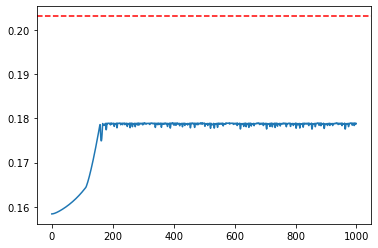

In [8]:
import matplotlib
import matplotlib.pyplot as plt

plt.axhline(y=num, color='r', linestyle='--')
plt.plot(trend)
plt.show()

In [20]:
N = 20
D = 6
gamma = 0.005
delta = 0.001
# IBP LR - 0.5
val, trend, vg = compute_DIF_certification(sgd_model, f_epsilon, gamma, delta, 
                                       X_test, y_test, N=N, iters=1000, rettrend=True, lr = 10.0)

num, rew, phi = numerical_solution(sgd_model, delta, gamma, N, D)

print(num)
print(float(val.detach()))



100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 396.45it/s]


Computing maximum value...


100%|█████████████████████████████████| 42504/42504 [00:00<00:00, 127516.96it/s]

0.2980793402181007
0.4031439423561096


In [21]:

v = I(sgd_model, X_test[0:N].float(), y_test[0:N].long(), f_epsilon, np.asarray([phi]).T, 2).detach().numpy()


In [22]:
print(np.mean(v))
print(float(val.detach()))

0.2980793
0.4031439423561096


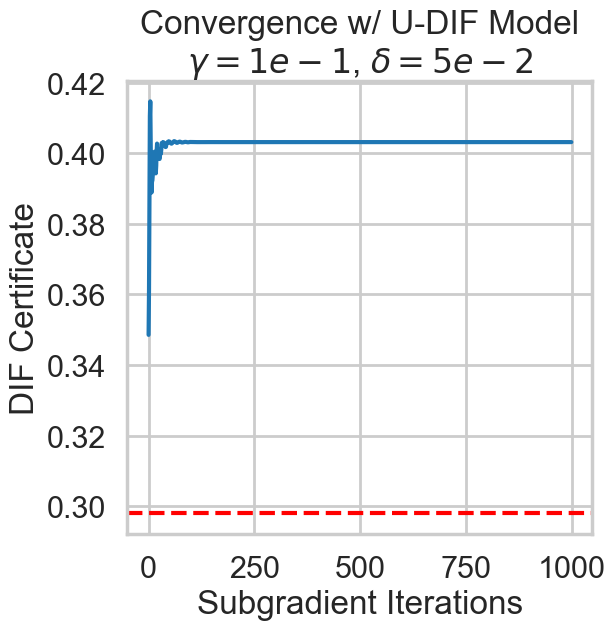

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('whitegrid')
plt.figure(figsize=(6,6), dpi=100)
plt.axhline(y=num, color='r', linestyle='--')
plt.plot(trend)
#plt.ylim((0.09, 0.145))
ax = plt.gca()
ax.set_title('Convergence w/ U-DIF Model\n$\gamma=1e-1$, $\delta=5e-2$', wrap=False)
plt.ylabel(r'DIF Certificate')
plt.xlabel('Subgradient Iterations')
plt.show()

#SGD - 
#gamma = 0.001
#delta = 0.0005

In [13]:

print(np.round(np.squeeze(vg.detach().numpy()), 2), np.mean(vg.detach().numpy()))
print(np.asarray(phi), np.mean(phi))


[0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51
 0.51 0.51 0.51 0.51 0.51 0.51] 0.51000005
[0.01 0.01 0.01 0.01 2.01 0.01 0.01 2.01 2.01 2.01 2.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01] 0.5099999999999998


In [14]:
from tqdm import trange
def numerical_checks(model, X_test, y_test, gamma, delta):
    D = 7
    avg_diff = 0
    num_checks = 0
    for n in range(16, 38, 2):
        num_checks += 1
        val_1, trend, vg = compute_DIF_certification(model, f_epsilon, gamma, delta, 
                                       X_test, y_test, N=n, iters=500, rettrend=True,
                                                   lr = 1.0)
        val_2, trend, vg = compute_DIF_certification(model, f_epsilon, gamma, delta, 
                                       X_test, y_test, N=n, iters=750, rettrend=True,
                                                   lr = 0.1)
        val = max(val_1, val_2)
        num, rew, phi = numerical_solution(model, delta, gamma, n, D)
        print(val-num, val, num)
        avg_diff += (val - num)
    return avg_diff/num_checks

sgd_numerical_test = numerical_checks(sgd_model, X_test, y_test, 0.001, 0.0005)
pgd_numerical_test = numerical_checks(pgd_model, X_test, y_test, 0.01, 0.005)
ibp_numerical_test = numerical_checks(ibp_model, X_test, y_test, 0.1, 0.05)
glob_numerical_test = numerical_checks(glob_model, X_test, y_test, 0.1, 0.05)
ibpg_numerical_test = numerical_checks(ibpg_model, X_test, y_test, 0.1, 0.05)

100%|████████████████████████████████████████| 750/750 [00:01<00:00, 407.98it/s]


Computing maximum value...


100%|█████████████████████████████████| 54264/54264 [00:00<00:00, 146621.05it/s]


tensor(-0.0238, grad_fn=<SubBackward0>) tensor(0.1344, grad_fn=<MeanBackward0>) 0.15821299421077128


100%|████████████████████████████████████████| 750/750 [00:01<00:00, 409.13it/s]


Computing maximum value...


100%|███████████████████████████████| 100947/100947 [00:00<00:00, 136999.14it/s]


tensor(-0.0267, grad_fn=<SubBackward0>) tensor(0.1256, grad_fn=<MeanBackward0>) 0.15236002816042551


100%|████████████████████████████████████████| 750/750 [00:02<00:00, 287.53it/s]


Computing maximum value...


100%|███████████████████████████████| 177100/177100 [00:01<00:00, 128577.54it/s]


tensor(-0.0238, grad_fn=<SubBackward0>) tensor(0.1237, grad_fn=<MeanBackward0>) 0.14753888201666995


100%|████████████████████████████████████████| 750/750 [00:01<00:00, 417.17it/s]


Computing maximum value...


100%|███████████████████████████████| 296010/296010 [00:02<00:00, 120860.41it/s]


tensor(-0.0120, grad_fn=<SubBackward0>) tensor(0.1324, grad_fn=<MeanBackward0>) 0.14435140846762806


100%|████████████████████████████████████████| 750/750 [00:01<00:00, 395.24it/s]


Computing maximum value...


100%|███████████████████████████████| 475020/475020 [00:04<00:00, 111951.48it/s]


tensor(-0.0145, grad_fn=<SubBackward0>) tensor(0.1272, grad_fn=<MeanBackward0>) 0.14179602066481797


100%|████████████████████████████████████████| 750/750 [00:01<00:00, 387.59it/s]


Computing maximum value...


100%|███████████████████████████████| 736281/736281 [00:06<00:00, 106524.28it/s]


tensor(-0.0165, grad_fn=<SubBackward0>) tensor(0.1244, grad_fn=<MeanBackward0>) 0.1409807791485666


100%|████████████████████████████████████████| 750/750 [00:01<00:00, 377.21it/s]


Computing maximum value...


  0%|                                 | 2643/1107568 [00:00<00:11, 95697.87it/s]


KeyboardInterrupt: 

In [ ]:

print(float(sgd_numerical_test))
print(float(pgd_numerical_test))
print(float(ibp_numerical_test))
print(float(glob_numerical_test))
print(float(ibpg_numerical_test))
# Number of checks needed: 
total_numerical_evals = 54264 + 100947 + 177100 + 296010 + 475020 + 736281 + 1107568 + 1623160 + 2324784 + 3262623 + 4496388
#14_654_145
print(total_numerical_evals)
# Errors - Income:
"""
-0.014322156086564064
0.06885955482721329
0.00820833444595337
0.058401964604854584
-0.002134484937414527
"""
# Errors - Adult:
"""
0.037066909670829773
0.036596205830574036
-0.0009804845321923494
-0.0013229125179350376
0.008271366357803345
"""
# Errors - Credit:
"""
0.11321992427110672
-0.033412933349609375
0.022244466468691826
0.01889326050877571
-0.007846537977457047
"""